In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Single harmonic oscillator

In [2]:
freq = 2.  # Hz
omega = 2. * np.pi * freq

tmax = 10  # s
Nt = 10000
sfreq = Nt / tmax

tv = np.linspace(0., tmax, Nt)

def f(X, t):
    x, dotx = X
    ddotx = -omega**2 * x
    return [dotx, ddotx]

In [3]:
%%time
X = odeint(f, [1., 0.], tv)

CPU times: user 7.26 ms, sys: 710 µs, total: 7.97 ms
Wall time: 7.46 ms


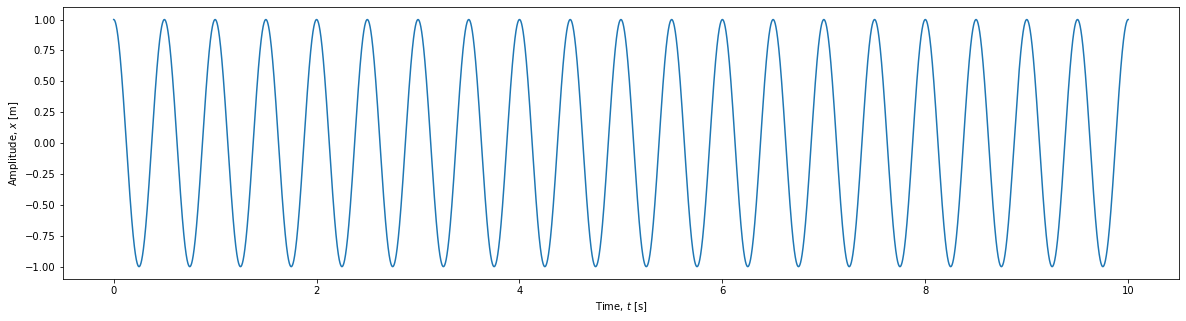

In [4]:
plt.figure(figsize=(20, 5))
plt.plot(tv, X[:, 0], "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.show()

# Phase model

In [5]:
def fp(p, t):
    dotp = omega * Nt
    return dotp

In [6]:
%%time
Phi = odeint(fp, np.pi/2, tv)

CPU times: user 727 µs, sys: 262 µs, total: 989 µs
Wall time: 817 µs


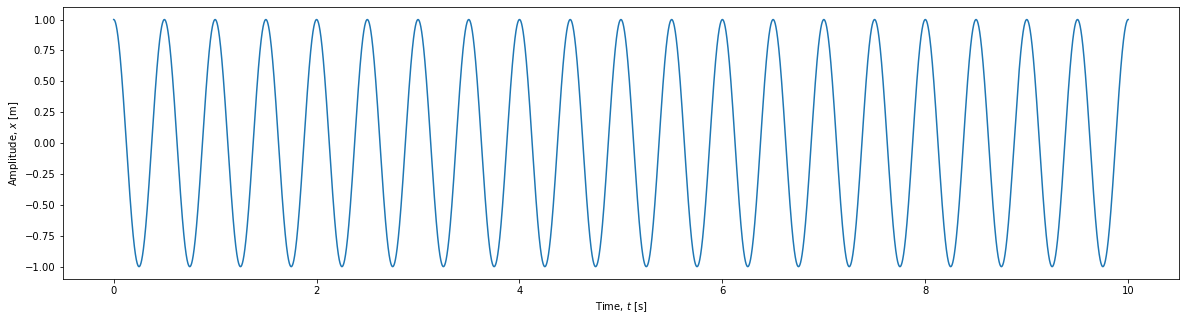

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(tv, np.sin(Phi), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.show()

# Two oscillators

In [8]:
N_osc = 2

Omega = omega + np.random.randn(N_osc) / Nt
Noise = np.ones(N_osc) / Nt
Coupling = 0.5 * np.ones(N_osc)

In [9]:
def fp(p, t):
    C = np.sin(np.array([p[1]-p[0], p[0]-p[1]]))
    dotp = Omega * Nt * np.ones(N_osc) + Noise * np.random.randn(N_osc) + Coupling * C
    return dotp

In [10]:
%%time
Phi = odeint(fp, 2 * np.pi * np.random.rand(N_osc), tv)

CPU times: user 7.95 ms, sys: 2.4 ms, total: 10.3 ms
Wall time: 8.49 ms


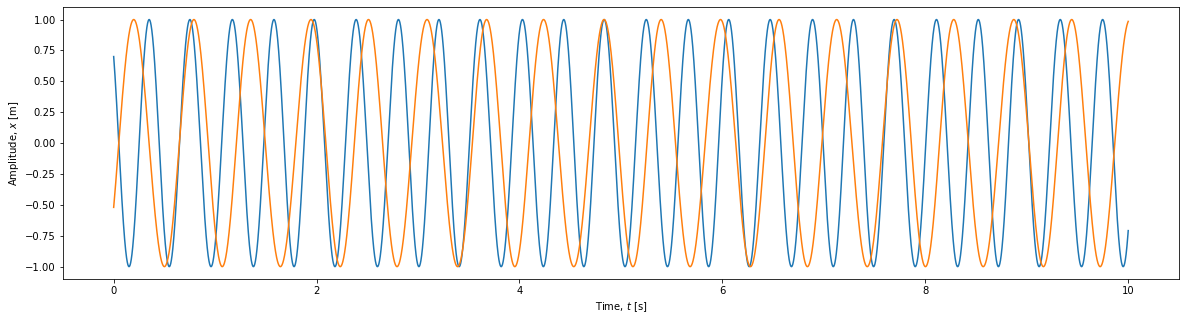

In [11]:
plt.figure(figsize=(20, 5))
plt.plot(tv, np.sin(Phi), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.show()

# N oscillators with uniform coupling

In [12]:
N_osc = 10

Omega = omega + np.random.randn(N_osc) / Nt
Noise = np.ones(N_osc) * 1 / Nt
Coupling = 0.3 * np.ones(N_osc)

In [13]:
def fp(p, t):
    p = np.atleast_2d(p)
    C = np.sum(np.sin(p).T.dot(np.cos(p)) - np.cos(p).T.dot(np.sin(p)), 0)
    dotp = Omega * Nt * np.ones(N_osc) + Noise * np.random.randn(N_osc) + Coupling * C
    return dotp

In [14]:
%%time
Phi = odeint(fp, 2 * np.pi * np.random.rand(N_osc), tv)

CPU times: user 21.4 ms, sys: 3.42 ms, total: 24.8 ms
Wall time: 23.1 ms


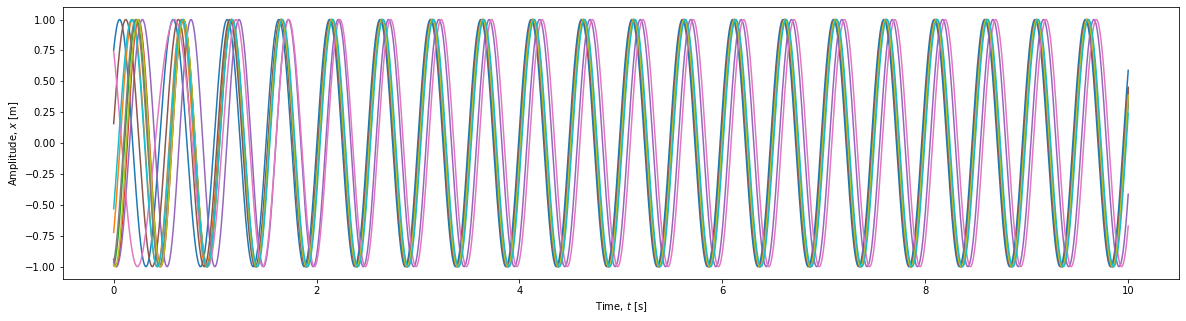

In [15]:
plt.figure(figsize=(20, 5))
plt.plot(tv, np.sin(Phi), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.show()

# N oscillators with generalized coupling

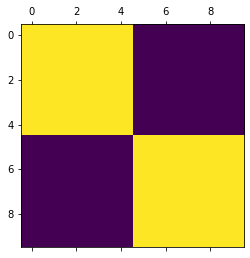

In [16]:
frequency_mean = 2.  # Hz
frequency_std = 0.5 # Hz

noise_phase_level = 1 / sfreq
noise_amplitude_level = 0.

N = int(N_osc/2)
A11 = 1 * np.ones((N, N))
A12 = 0 * np.ones((N, N))
A21 = 0 * np.ones((N, N))
A22 = 1 * np.ones((N, N))
W = np.block([[A11, A12], [A21, A22]])
W = 0.9 * W
plt.matshow(W)

In [17]:
freq = frequency_mean + frequency_std * np.random.randn(N_osc)
omega = 2. * np.pi * freq
p0 = 2 * np.pi * np.block([np.zeros(N), np.zeros(N) + np.random.rand(N) + 0.5])

def fp(p, t):
    p = np.atleast_2d(p)
    coupling = np.squeeze((np.sin(p) * np.matmul(W, np.cos(p).T).T) - (np.cos(p) * np.matmul(W, np.sin(p).T).T))
    dotp = omega - coupling + noise_phase_level * np.random.randn(N_osc)
    return dotp

/Users/kwisatz/anaconda3/lib/python3.7/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


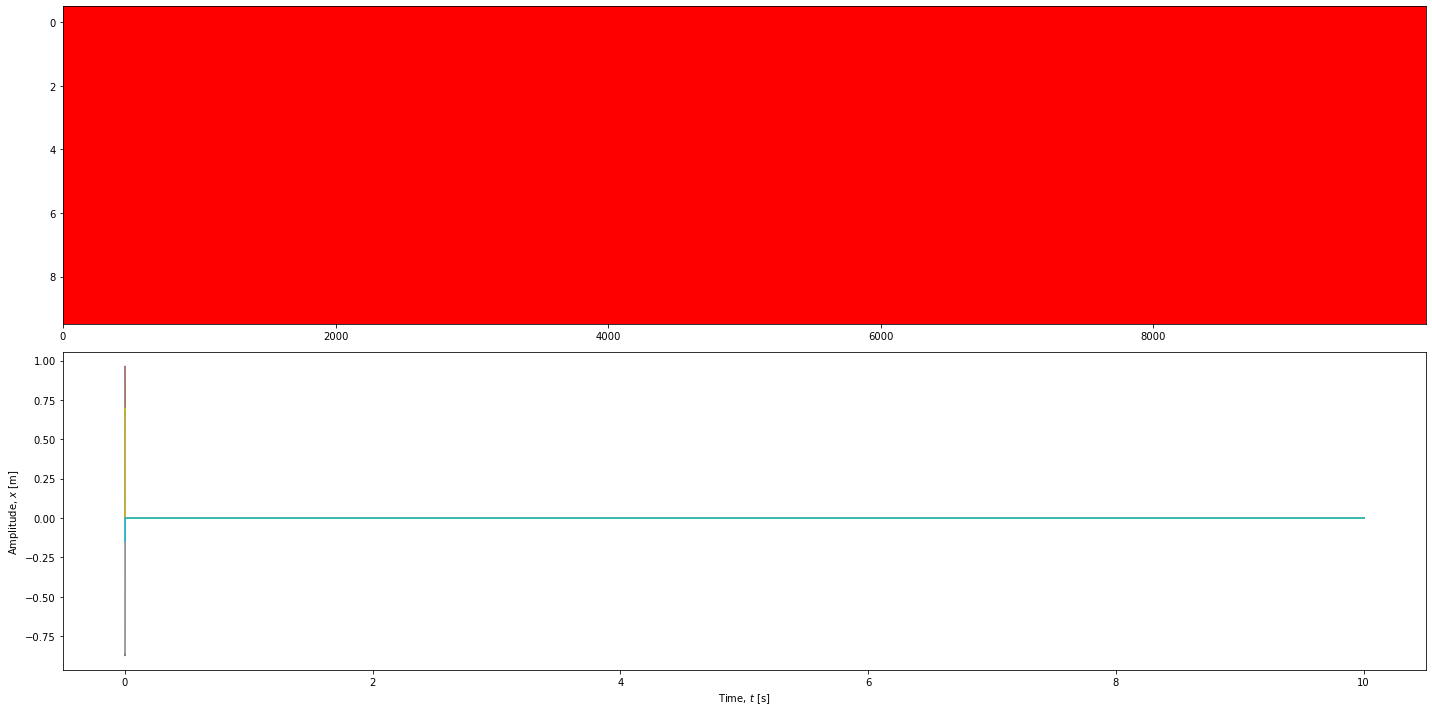

CPU times: user 559 ms, sys: 38.9 ms, total: 597 ms
Wall time: 587 ms


In [18]:
%%time
Phi = odeint(fp, p0, tv) % (2*np.pi)

plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.imshow(Phi.T,interpolation='none', cmap='hsv', aspect='auto')
plt.subplot(2,1,2)
plt.plot(tv, np.sin(Phi), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.tight_layout()
plt.show()

In [19]:
def rungekutta4(f, y0, t, args=()):
    n = len(t)
    y = np.zeros((n, len(y0)))
    y[0] = y0
    for i in range(n - 1):
        h = t[i+1] - t[i]
        k1 = f(y[i], t[i], *args)
        k2 = f(y[i] + k1 * h / 2., t[i] + h / 2., *args)
        k3 = f(y[i] + k2 * h / 2., t[i] + h / 2., *args)
        k4 = f(y[i] + k3 * h, t[i] + h, *args)
        y[i+1] = y[i] + (h / 6.) * (k1 + 2*k2 + 2*k3 + k4)
    return y

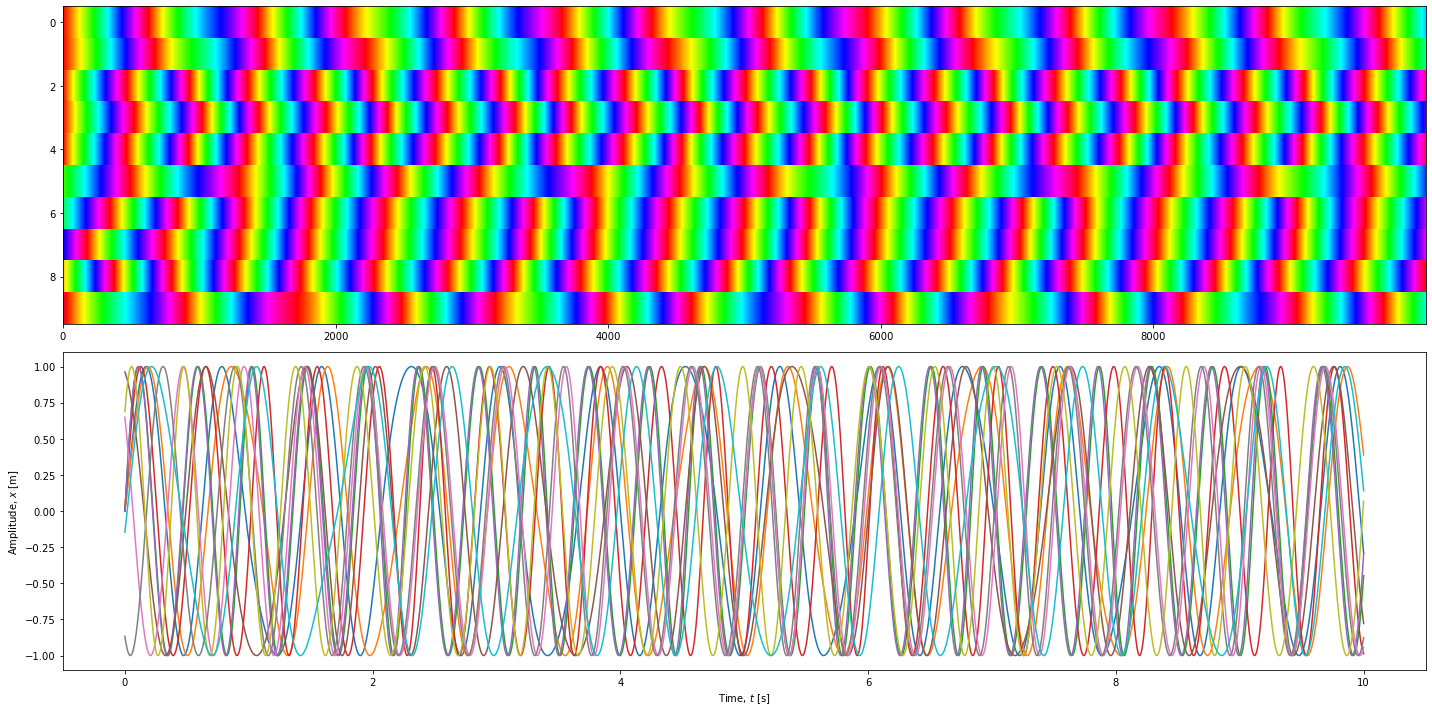

CPU times: user 1.63 s, sys: 43.8 ms, total: 1.68 s
Wall time: 1.67 s


In [20]:
%%time
Phi = rungekutta4(fp, p0, tv) % (2*np.pi)

plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.imshow(Phi.T,interpolation='none', cmap='hsv', aspect='auto')
plt.subplot(2,1,2)
plt.plot(tv, np.sin(Phi), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.tight_layout()
plt.show()

In [21]:
from scipy.integrate import solve_ivp

def fp(t, p):
    p = np.atleast_2d(p)
    coupling = np.squeeze((np.sin(p) * np.matmul(W, np.cos(p).T).T) - (np.cos(p) * np.matmul(W, np.sin(p).T).T))
    dotp = omega - coupling + noise_phase_level * np.random.randn(N_osc)
    return dotp

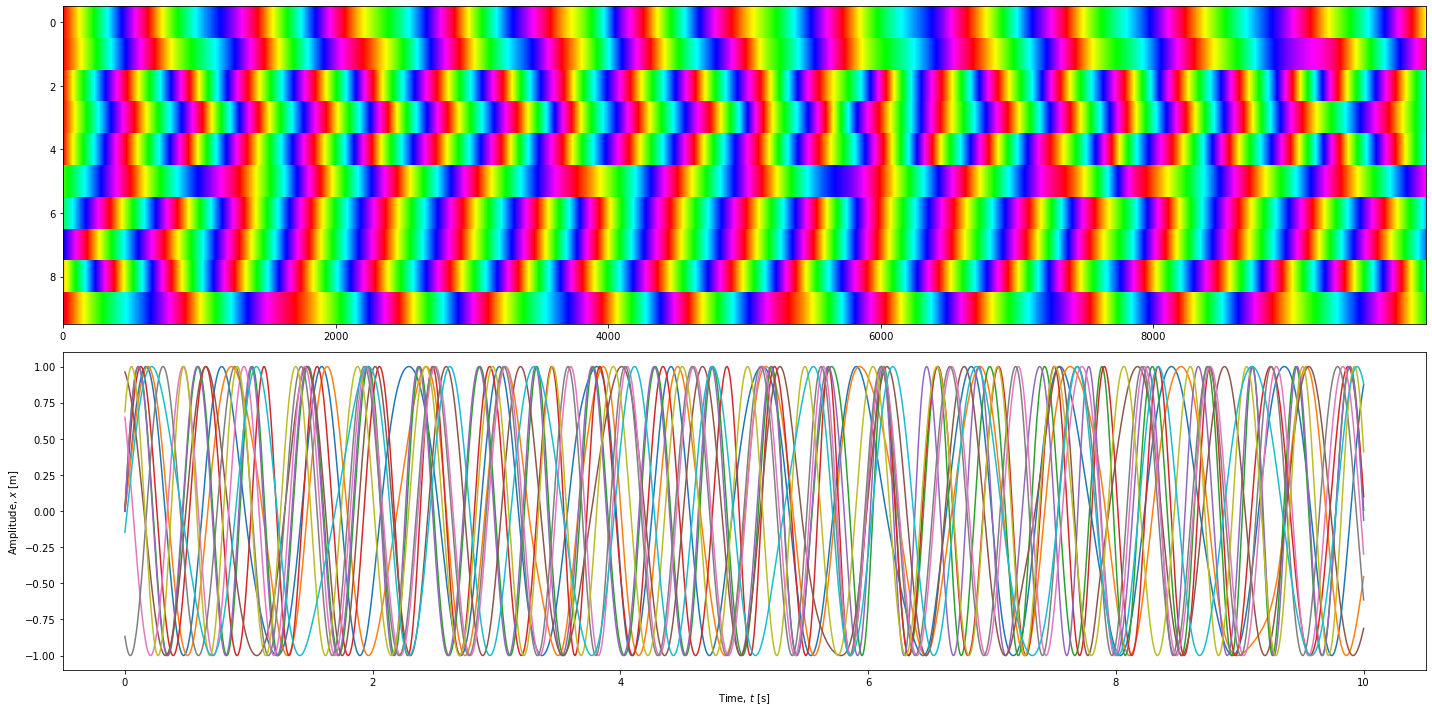

CPU times: user 468 ms, sys: 23.3 ms, total: 491 ms
Wall time: 492 ms


In [22]:
%%time
ans = solve_ivp(fun=fp, t_span=(tv[0], tv[-1]), y0=p0, t_eval=tv)

Phi = ans['y'].T  % (2*np.pi)
plt.figure(figsize=(20, 10))
plt.subplot(2,1,1)
plt.imshow(Phi.T,interpolation='none', cmap='hsv', aspect='auto')
plt.subplot(2,1,2)
plt.plot(tv, np.sin(Phi), "-")
plt.xlabel("Time, $t$ [s]")
plt.ylabel("Amplitude, $x$ [m]")
plt.tight_layout()
plt.show()